In [1]:
from typing_extensions import Literal, Annotated 
from langchain_core.tools import tool
from langchain_groq import ChatGroq
from langgraph.graph import MessagesState, StateGraph,START,END
from langgraph.types import Command
from dotenv import load_dotenv
from IPython.display import Image, display
from langchain_core.messages import BaseMessage, HumanMessage
from langgraph.prebuilt import create_react_agent
from typing import Annotated
from langchain_experimental.utilities import PythonREPL
import os

In [2]:
load_dotenv()

True

In [3]:
GOOGLE_API_KEY = os.getenv("GOOGLE_API_KEY")
TAVILY_API_KEY = os.getenv("TAVILY_API_KEY")
GROQ_API_KEY = os.getenv("GROQ_API_KEY")
LANGCHAIN_API_KEY = os.getenv("LANGCHAIN_API_KEY")
LANGSMITH_PROJECT = os.getenv("LANGSMITH_PROJECT")
HUGGINGFACE_API_KEY = os.getenv("HUGGINGFACE_API_KEY")
SERPER_API_KEY = os.getenv("SERPER_API_KEY")
LANGCHAIN_TRACING = os.getenv("LANGCHAIN_TRACING")
LANGSMITH_ENDPOINT = os.getenv("LANGSMITH_ENDPOINT")

os.environ["GOOGLE_API_KEY"] = GOOGLE_API_KEY
os.environ["TAVILY_API_KEY"] = TAVILY_API_KEY
os.environ["GROQ_API_KEY"] = GROQ_API_KEY
os.environ["LANGCHAIN_API_KEY"] = LANGCHAIN_API_KEY
os.environ["LANGSMITH_PROJECT"] = LANGSMITH_PROJECT
os.environ["HUGGINGFACE_API_KEY"] = HUGGINGFACE_API_KEY
os.environ["SERPER_API_KEY"] = SERPER_API_KEY

os.environ["LANGCHAIN_TRACING"] = LANGCHAIN_TRACING
os.environ["LANGSMITH_ENDPOINT"] = LANGSMITH_ENDPOINT


In [4]:
from langchain_groq import ChatGroq

llm = ChatGroq(model_name = "llama-3.3-70b-versatile")

In [5]:
llm2 = ChatGroq(model_name = "deepseek-r1-distill-llama-70b")

Agent 1 will be the researcher agent and Agent 2 will be the analyst agent.

We will pass the input to the first agent and it will search the internet for related information and then it will pass the information to the analyst agent and it will interpret the results using a python code.

Both the agents are ReAct agents. 

There will be a loop between both the agents and the loop will continue until we have a perfect final answer. 

In [6]:
from langchain_community.tools import DuckDuckGoSearchRun
search_tool = DuckDuckGoSearchRun()

In [7]:
search_tool.invoke("Who is Ronaldo?")

/Users/atharvabot7/Downloads/MLOPS-Tutorials/LangGraph/langgraph/lib/python3.10/site-packages/langchain_community/utilities/duckduckgo_search.py:63: RuntimeWarning: This package (`duckduckgo_search`) has been renamed to `ddgs`! Use `pip install ddgs` instead.
  with DDGS() as ddgs:


'No good DuckDuckGo Search Result was found'

In [8]:
repl = PythonREPL()

In [9]:
code = """ 
x = 5
y = x * 2
print(y)
"""

In [10]:
repl.run(code)

Python REPL can execute arbitrary code. Use with caution.


'10\n'

In [11]:
@tool 
def python_repl_tool(
    code: Annotated[str, "The python code to execute to generate your chart."],
):
    """
    Use this tool to execute python code. If you want to see the output of a value, 
    you should print it out with 'print(...)'. This is visible to the user.
    """
    try: 
        result = repl.run(code)
    except BaseException as e:
        return f"Failed to execute code with error: {repr(e)}"
    
    result_str = f"Successfully executed code. The output was:\n{result}"

    return (
        result_str + "\n\n If you have completed all the tasks, respond with FINAL ANSWER'"
    )

In [12]:
def make_system_prompt(instruction: str) -> str:
    return (
        "You are a highly intelligent and capable AI assistant who has the capability to collaborate with other agents to complete complex tasks."
        "Use the provided tools to progress towards the final answer."
        "If you are unable to fully answer the question, that is okay, another assistant with different tools will help you where you left off. Execute what you " 
        "can to make progress. If you or the other assistants have the final answer or deliverable, prefix your response with FINAL ANSWER: so the team knows where to stop."
        f"\n{instruction}"
    )

In [13]:
def get_next_node(last_message: BaseMessage, goto: str):
    if "FINAL ANSWER" in last_message.content:
        return END
    return goto

In [14]:
research_agent = create_react_agent(
    llm,
    tools=[search_tool],
    prompt = make_system_prompt(
        "You can only perform research by surfing the internet. You are going to work with chart generation agent to complete the final deliverable."
    ),
)

In [15]:
chart_agent = create_react_agent(
    llm,
    tools=[python_repl_tool],
    prompt = make_system_prompt(
        "You can only generate charts. You are going to work with research agent to complete the final deliverable. The final deliverable is a report with charts."
    ),
)

In [16]:
def research_node(state: MessagesState) -> Command[Literal["chart_generator", END]]:
    result = research_agent.invoke(state)

    goto = get_next_node(result["messages"][-1], "chart_generator")

    result["messages"][-1] = HumanMessage(content=result["messages"][-1].content, name = "researcher")
    
    return Command(update = {"messages": result["messages"]}, goto=goto)

In [17]:
def chart_node(state: MessagesState) -> Command[Literal["researcher", END]]:
    result = chart_agent.invoke(state)

    goto = get_next_node(result["messages"][-1], "researcher")

    result["messages"][-1] = HumanMessage(content=result["messages"][-1].content, name = "chart_generator")
    
    return Command(update = {"messages": result["messages"]}, goto=goto)

In [18]:
from langgraph.graph import StateGraph, START, END

workflow = StateGraph(MessagesState)

In [19]:
workflow.add_node("researcher", research_node)
workflow.add_node("chart_generator", chart_node)

In [20]:
workflow.add_edge(START, "researcher")

In [21]:
app = workflow.compile()

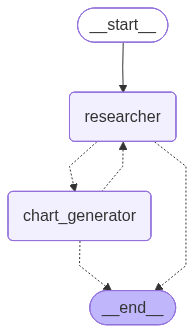

In [22]:
display(Image(app.get_graph().draw_mermaid_png()))

In [24]:
app.invoke({"messages": [("user","top 5 countries of the world wrt population and then create a pie chart of them")],})

/Users/atharvabot7/Downloads/MLOPS-Tutorials/LangGraph/langgraph/lib/python3.10/site-packages/langchain_community/utilities/duckduckgo_search.py:63: RuntimeWarning: This package (`duckduckgo_search`) has been renamed to `ddgs`! Use `pip install ddgs` instead.
  with DDGS() as ddgs:
/Users/atharvabot7/Downloads/MLOPS-Tutorials/LangGraph/langgraph/lib/python3.10/site-packages/langchain_community/utilities/duckduckgo_search.py:63: RuntimeWarning: This package (`duckduckgo_search`) has been renamed to `ddgs`! Use `pip install ddgs` instead.
  with DDGS() as ddgs:


{'messages': [HumanMessage(content='top 5 countries of the world wrt population and then create a pie chart of them', additional_kwargs={}, response_metadata={}, id='534b6cad-7499-4c8b-bc4d-03aa41a2e984'),
  AIMessage(content='To find the top 5 countries by population, I will first need to search for the current population of countries. \n\n', additional_kwargs={'tool_calls': [{'id': 'kvc8t49n1', 'function': {'arguments': '{"query":"top 5 countries by population"}', 'name': 'duckduckgo_search'}, 'type': 'function'}]}, response_metadata={'token_usage': {'completion_tokens': 46, 'prompt_tokens': 407, 'total_tokens': 453, 'completion_time': 0.129143609, 'prompt_time': 0.035721491, 'queue_time': 0.209952364, 'total_time': 0.1648651}, 'model_name': 'llama-3.3-70b-versatile', 'system_fingerprint': 'fp_155ab82e98', 'service_tier': 'on_demand', 'finish_reason': 'tool_calls', 'logprobs': None}, id='run--76f51411-5295-42aa-a77f-a11b12223424-0', tool_calls=[{'name': 'duckduckgo_search', 'args': {